
# **Grupo 3 - Utilizando Algoritmo de Grover para encontrar números aleatórios**


**Objetivo:**
Nosso projeto tem como objetivo utilizar o princípio do Algorítmo de Grover para encontrar, de forma mais rápida e precisa que um algorítmo clássico, um número gerado aleatoriamente utlizando o conceito de superposição de estados quânticos de um qubit.

**Resultados esperados:**
É esperado que o algorítmo quântico seja capaz de encontrar o número gerado aleatoriamente utilizando-se de muito menos tentativas que um algorítmo clássico.

---
Metodologia
O projeto foi dividido em duas abordagens:

Busca Quântica (Grover): usa o simulador AerSimulator do Qiskit para preparar o circuito, aplicar o oráculo e o difusor, e medir o resultado.

Busca Clássica: o algoritmo percorre todas as combinações possíveis até encontrar a senha correta.
Em ambos os casos, comparamos o número de tentativas e a probabilidade de sucesso.


In [57]:
#instalando a biblioteca qiskit
#!pip install -q qiskit qiskit-aer pylatexenc matplotlib

In [58]:
#importando bibliotecas necessárias
%matplotlib inline
import qiskit, math
from IPython.display import display
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit.library import *
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector, plot_state_qsphere, plot_state_city, plot_histogram
from qiskit_aer import Aer, AerSimulator
from qiskit.providers.basic_provider import BasicSimulator
import numpy as np
import random
import matplotlib.pyplot as plt

O Algoritmo de Grover é utilizado para fazer pesquisas em bancos de dados muito extensos de forma muito mais rápida que o método tradicional clássico, utilizando o princípio da interferência quântica.

Interferência Quântica: Os qubits operam a partir do princípio da dualidade da onda-partícula. Graças a isso, utilizaremos a propriedade de onda dos qubits para fazer uma interferência de ondas.

Este algoritmo pode ser dividido em 6 passos:

1 - Input:O algoritmo recebe um input com o item que desejamos encontrar dentro de uma lista.

2 - Inicialização: Colocamos todos os qubits em estado de superposição para aplicarmos nossas ondas transformadas pelo Oráculo e Difusor. Para isso, aplicamos a porta Hadamard em todas elas.

3 - Oráculo: O Oráculo tem a principal função de receber o input e inverter a fase do seu estado.

4 - Difusor: O Difusor vai aplicar uma inversão de onda, fazendo com que haja interferência construtiva em cima da onda invertida (representada por Y na imagem abaixo) e interferência destrutiva nas demais ondas.
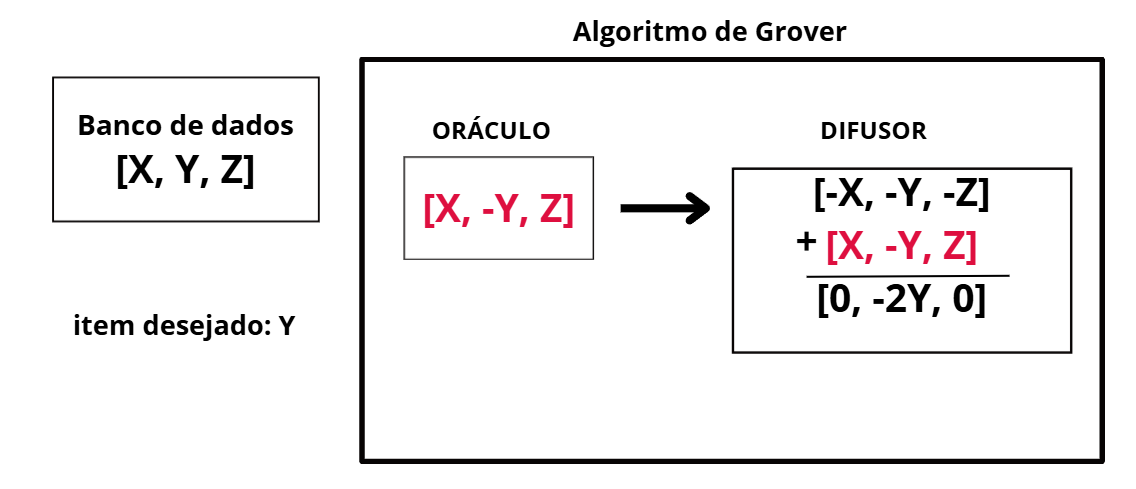

Atenção! Essa imagem não representa o algoritmo de forma fiel. É apenas uma representação visual fazendo uma analogia simplificada com fins didáticos.

5 - Iteração: Esta etapa consiste na repetição do ciclo Oráculo (Etapa 3) e Difusor (Etapa 4). A cada passagem, a amplitude de probabilidade do estado da solução é amplificada por meio de interferência construtiva, garantindo que a probabilidade de medir o resultado correto seja maximizada.

6 - Conversão: Nessa etapa, depois que os qubits passarem por todo o algoritmo, vamos converter esses qubits para bits clássicos, fornecendo o resultado esperado, ou seja, a localização do nosso output.


# 1 – ENTRADA / DEFINIÇÃO DE PARÂMETROS

---



In [59]:
def get_psswd(num_qubits):
  senha = random.randint(0, 2**num_qubits - 1)  # Senha aleatória entre 0 e 2^n - 1
  senha_bin = format(senha, f'0{num_qubits}b')  # Converte senha para binário ex: 01011011
  return senha, senha_bin


# 2 – ORÁCULO (INVERSOR DE FASE)

---

O oráculo é o "marcador" do algoritmo: ele identifica a senha correta
e inverte a fase (sinal da amplitude) apenas desse estado.
É equivalente a perguntar "essa é a senha certa?" simultaneamente
para todas as combinações possíveis.

Portas usadas:
- $X$: Pauli-X (NOT quântico), inverte $|0⟩ ↔ |1⟩$.
- $H$: Hadamard, cria superposição e alterna base computacional $↔$ base de fase.
- $MCX$: Multi-Controlled X, inverte um qubit alvo apenas se todos os qubits de controle = 1.

In [60]:
def oracle(circuit, senha_bin, num_qubits):
    # 1. Aplica X nos qubits que representam '0' na senha.
    #    Isso transforma o estado alvo (senha) em |111...1⟩
    #    para que a porta MCX o reconheça.
    for i, bit in enumerate(reversed(senha_bin)):
        if bit == '0':
            circuit.x(i)  # Porta X (NOT quântico)

    # 2. Aplica uma inversão de fase controlada:
    #    - H: muda a base para transformar a inversão de fase em inversão de amplitude.
    #    - MCX: inverte a fase do estado |111...1⟩ (equivalente à senha correta).
    #    - H: retorna à base original.
    circuit.h(num_qubits - 1)  # Porta Hadamard
    circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1)  # Multi-Controlled-X
    circuit.h(num_qubits - 1)  # Porta Hadamard

    # 3. Desfaz as inversões iniciais (retorna os qubits ao estado original)
    for i, bit in enumerate(reversed(senha_bin)):
        if bit == '0':
            circuit.x(i)  # Porta X novamente (reverte a preparação)



# 3 – DIFUSOR (INVERSÃO SOBRE A MÉDIA)

---

O difusor amplifica a probabilidade da senha correta.
Ele reflete todos os estados em torno da média de amplitudes —
o que aumenta o destaque do estado marcado pelo oráculo.

Portas usadas:
- $H$: Hadamard, alterna entre bases de amplitude e fase.
- $X$: Pauli-X ($NOT$), prepara os estados invertidos para aplicar o $MCX$.
- $MCX$: Inversão controlada, usada para refletir os estados.
- A sequência $H=>X=>H$ cria a "inversão sobre a média".

In [61]:
def diffuser(circuit, num_qubits):
    # 1. Aplica H e X para mover o espaço de estados à base onde a média é refletida.
    circuit.h(range(num_qubits))  # Cria superposição uniforme
    circuit.x(range(num_qubits))  # Inverte |0⟩ ↔ |1⟩

    # 2. Inverte o estado |111...1⟩ (reflexão no eixo da média)
    circuit.h(num_qubits - 1)
    circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    circuit.h(num_qubits - 1)

    # 3. Desfaz as transformações (volta à base computacional)
    circuit.x(range(num_qubits))
    circuit.h(range(num_qubits))


# 4 – INICIALIZAÇÃO DO CIRCUITO

---

Todos os qubits começam no estado $|0⟩$.
Aplicamos uma porta Hadamard ($H$) em cada qubit para colocá-los
em uma superposição uniforme de todos os estados possíveis (de $0$ até $2^n - 1$).

Assim, o circuito começa com a superposição:
$$
|ψ₀⟩ = (1/√N) Σ |x⟩, onde N = 2^n.
$$


In [62]:
def init_circ(num_qubits):
  qr = QuantumRegister(num_qubits)
  cr = ClassicalRegister(num_qubits)
  circuit = QuantumCircuit(qr, cr)

  circuit.h(qr)  # Porta Hadamard em todos os qubits
  return circuit, qr, cr


# 5 – ITERAÇÕES DE GROVER (ORÁCULO + DIFUSOR)

---

Cada iteração aumenta a probabilidade de medir a senha correta.
O número ótimo de iterações é ≈ (π/4) * √N, onde N =  num_qubits. \



In [63]:
def iterar(circuit, num_qubits, senha_bin):
  iterations = int(np.pi / 4 * np.sqrt(2 ** num_qubits))
  for _ in range(iterations):
      oracle(circuit, senha_bin, num_qubits)
      diffuser(circuit, num_qubits)
  return iterations


# 6 – MEDIÇÃO

---

A medição converte o estado quântico (superposição) em um valor clássico.

Cada qubit colapsa em $|0⟩$ ou $|1⟩$.

O estado da senha correta deve aparecer com alta probabilidade.

In [64]:
def measure_circ(circuit, shots, qr, cr):
  circuit.measure(qr, cr)  # Mede todos os qubits

  sim = AerSimulator()
  compiled = transpile(circuit, sim)
  job = sim.run(compiled, shots=shots)
  result = job.result()
  counts = result.get_counts()

  circuit.draw('mpl')
  return counts

Agora vamos comparar os resultados gerados pelo Algoritmo de Grover com um algoritmo clássico.


--- 2 QUBITS ---
Senha: 1 (binário: 01)
Clássico: 3 tentativas
Quântico: 1 iterações (~√N = 2)
Resultado mais provável: 1 com 100.00% de probabilidade
Tempo de execução: 0.21857727299993712 s

--- 3 QUBITS ---
Senha: 4 (binário: 100)
Clássico: 6 tentativas
Quântico: 2 iterações (~√N = 2)
Resultado mais provável: 4 com 94.80% de probabilidade
Tempo de execução: 0.2838551759996335 s

--- 4 QUBITS ---
Senha: 0 (binário: 0000)
Clássico: 7 tentativas
Quântico: 3 iterações (~√N = 4)
Resultado mais provável: 0 com 95.60% de probabilidade
Tempo de execução: 0.3935510739993333 s

--- 5 QUBITS ---
Senha: 2 (binário: 00010)
Clássico: 27 tentativas
Quântico: 4 iterações (~√N = 5)
Resultado mais provável: 2 com 99.90% de probabilidade
Tempo de execução: 0.469643270999768 s

--- 6 QUBITS ---
Senha: 61 (binário: 111101)
Clássico: 51 tentativas
Quântico: 6 iterações (~√N = 8)
Resultado mais provável: 61 com 99.40% de probabilidade
Tempo de execução: 0.675085296999896 s

--- 7 QUBITS ---
Senha: 117 (b

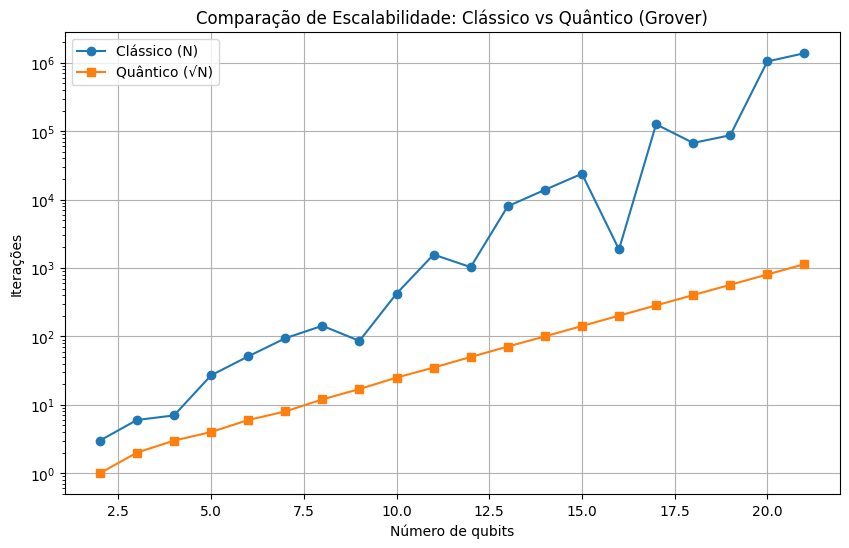

In [74]:
def tentar_classico(num_qubits, senha):
  tentativas_classicas = 0  # força bruta
  todas_as_senhas = list(range(0, 2** num_qubits))  # espaço de busca
  random.shuffle(todas_as_senhas)  # embaralha
  for tentativa in todas_as_senhas:  # busca clássica
      tentativas_classicas += 1
      if tentativa == senha:
          tentativa_bruta = tentativa
          break
  return tentativas_classicas, tentativa_bruta

import time

dados_classico = []
dados_quantico = []
tempo = 0

for num_qubits in range(2, 100):  # evita num_qubits=0 e 1 (não faz sentido)
    if tempo > 60 * 10: break
    start = time.perf_counter()

    senha, senha_bin = get_psswd(num_qubits)
    circuit, qr, cr = init_circ(num_qubits)
    iterations = iterar(circuit, num_qubits, senha_bin)
    counts = measure_circ(circuit, 1000, qr, cr)
    tentativas_classicas, tentativa_bruta = tentar_classico(num_qubits, senha)

    quantum_found = max(counts, key=counts.get)
    quantum_prob = counts[quantum_found] / sum(counts.values())

    print(f"\n--- {num_qubits} QUBITS ---")
    print(f"Senha: {senha} (binário: {senha_bin})")
    print(f"Clássico: {tentativas_classicas} tentativas")
    print(f"Quântico: {iterations} iterações (~√N = {int(np.sqrt(2**num_qubits))})")
    print(f"Resultado mais provável: {int(quantum_found, 2)} com {quantum_prob:.2%} de probabilidade")

    dados_classico.append(tentativas_classicas)
    dados_quantico.append(iterations)

    end = time.perf_counter()
    tempo = end - start
    print(f"Tempo de execução: {tempo} s")

# --- Gráfico comparativo ---
plt.figure(figsize=(10,6))
plt.plot(range(2, 2 + len(dados_classico)), dados_classico, 'o-', label='Clássico (N)')
plt.plot(range(2, 2 + len(dados_quantico)), dados_quantico, 's-', label='Quântico (√N)')
plt.yscale('log')
plt.xlabel('Número de qubits')
plt.ylabel('Iterações')
plt.title('Comparação de Escalabilidade: Clássico vs Quântico (Grover)')
plt.legend()
plt.grid(True)
plt.show()


# Conclusão, análise de resultados e expectativas

A partir dos resultados, conseguimos ver que o Algoritmo de Grover conseguiu encontrar o input (senha) em uma quantidade extremamente menor que o algoritmo clássico. Isso se deve a propriedade do Algoritmo de Grover de conseguir chegar a um resultado de uma lista N percorrendo, no pior dos casos, ${\pi \over 4}\sqrt{2^n}$
vezes, enquanto um algoritmo clássico, no pior dos casos, percorreria a lista toda, ou seja, N vezes.

A quantidade de qubits que podemos simular em um computador clássico é fisicamente limitada devido à grande quantidade de memória necessária no processo de simulação. Ainda assim, é possível perceber como a Computação Quântica é extremamente eficaz e mais eficiente do que a computação clássica.

Algoritmos como o de Grover podem ser extremamente úteis para tarefas em diversas áreas, tais como:

* **Análise de Dados:** Pode ser usado para acelerar a busca por uma informação específica em um banco de dados não estruturado. Um exemplo seria localizar uma transação bancária específica (feita por um cliente) em um extrato gigantesco que contenha todas as transferências de todos os clientes do banco.

* **Cibersegurança:** Pode ser utilizado para mensurar a segurança de um sistema de criptografia ao determinar a quantidade de iterações necessárias para encontrar a chave correta (quebrando a criptografia por força bruta).


Explorar as propriedades de onda dos qubits e utilizar sistemas quânticos para aproximar diferentes resultados pode nos ajudar a resolver cálculos extensos com diversas soluções em um tempo exponencialmente menor do que em computadores clássicos.

A Física Quântica abre diversas portas para áreas como Cibersegurança, Criptografia, Análise de Dados e Matemática em geral.

# Expectativas:

O tempo de simulação cresce exponencialmente de acordo o número de qubits e a simulação do algoritmo quântico demora mais em computador clássico do que a pesquisa clássica.
Em hardware clássico, o ruído pode reduzir a precisão.
O tamanho da simulação é limitado fisicamente à capacidade de memória do sistema



# Melhorias futuras:

Implementar um sistema de senha quântica que aceite qualquer tipo de caractere, incluindo números, letras e símbolos especiais, ampliando o espaço de busca e tornando o experimento mais próximo de um cenário real de segurança digital.
Buscar o menor números de iterações e manter uma alta porcentagem de acerto. Além disso, buscar a implementação de um oráculo baseado em regras de validação e não de decodificação da senha.